In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [2]:
import sympy as sp
import numpy as np 
import scipy.optimize

def jacobian(f, x0, u0, epsilon=0.001):
    
    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)
        
    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)
    
    return np.array(np.vstack(Aj)), np.array(np.vstack(Bj))

def __extended_kalman_forward_update__(xhat_fm, P_fm, y, u, A, B, C, D, R, Q, h, f):
    """
    Linear kalman update equations

    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    :return:
    """


    I = np.array(np.eye(A.shape[0]))
    gammaW = np.array(np.eye(A.shape[0]))

    K_f = P_fm@C.T@np.linalg.inv(C@P_fm@C.T + R)

    #xhat_fp = xhat_fm + K_f@(y - (C@xhat_fm+D@u))
    xhat_fp = xhat_fm + K_f@(y - h(xhat_fm, u))
    
    if xhat_fp[4,0] < 0.01:
        xhat_fp[4,0] = 0.01
    if xhat_fp[4,0] > 100:
        xhat_fp[4,0] = 100
        
    if xhat_fp[5,0] < -5:
        xhat_fp[5,0] = -5
    if xhat_fp[5,0] > 5:
        xhat_fp[5,0] = 5
    
    #xhat_fm = A@xhat_fp + B@u
    xhat_fm = f(xhat_fp, u)
    
    if xhat_fm[4,0] < 0.01:
        xhat_fm[4,0] = 0.01
    if xhat_fm[4,0] > 100:
        xhat_fm[4,0] = 100
        
    if xhat_fm[5,0] < -5:
        xhat_fm[5,0] = -5
    if xhat_fm[5,0] > 5:
        xhat_fm[5,0] = 5

    P_fp = (I - K_f@C)@P_fm
    P_fm = A@P_fp@A.T + gammaW@Q@gammaW.T

    return xhat_fp, xhat_fm, P_fp, P_fm

def ekf(y, x0, f, h, Q, R, u, P0=None):
    '''
    y -- 2D array of measurements, rows = measurements; columns = time points
    x0 -- 2D array of initial state (guess), rows = states; 1 column
    f -- discrete dynamics function that takes (state, control) as an input and returns a 2D (1 column) array
    h  -- discrete measurement function that takes (state, control) as an input and returns a 2D (1 column) array
    Q, R -- 2D square arrays corresponding to process and measurement covariance matrices, respectively
    u -- 2D array of controls, rows = measurements; columns = time points
    P0 -- optional, 2D array of initial error covariance (guess)
    '''

    nx = x0.shape[0]
    if P0 is None:
        P0 = np.array(np.eye(nx)*100)

    xhat_fp = None
    P_fp = []
    P_fm = [P0]
    xhat_fm = x0

    for i in range(y.shape[1]):
        
        A, B = jacobian(f, np.ravel(xhat_fm[:, -1:]), np.ravel(u[:, i:i+1]))
        C, D = jacobian(h, np.ravel(xhat_fm[:, -1:]), np.ravel(u[:, i:i+1]))

        _xhat_fp, _xhat_fm, _P_fp, _P_fm = __extended_kalman_forward_update__(xhat_fm[:, -1:], P_fm[-1], y[:, i:i+1], u[:, i:i+1],
                                                                              A, B, C, D, R, Q, h, f)
        if xhat_fp is None:
            xhat_fp = _xhat_fp
        else:
            xhat_fp = np.hstack((xhat_fp, _xhat_fp))
        xhat_fm = np.hstack((xhat_fm, _xhat_fm))
        
        P_fp.append(_P_fp)
        P_fm.append(_P_fm)

    s = np.zeros([nx,y.shape[1]]);
    for i in range(nx):
        s[i,:] = [np.sqrt( P_fm[j][i,i].squeeze() ) for j in range(y.shape[1])]

    return xhat_fm[:,0:-1], np.dstack(P_fm[0:-1]), s


In [3]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

In [4]:
# System Parameters
m = 2 # mass
l = 0.2 # distance from rotor to COM
#I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

# Noise for measurements:
v = [0.01, 0.001, 0.2, 0.2]

In [5]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = 3*np.sin(0.05*t)
    return theta_des, x_des, z_des

# Nominal trajectory, measurements

In [6]:
class PlanarDrone:
    def __init__(self):
        self.v = [0.01, 0.001, 0.2, 0.2]

    def control(self, X, t):
        theta, thetadot, x, xdot, mu, mudot = X

        # desired trajectory
        theta_des, x_des, z_des = desired_trajectory(t)

        z = 1/mu
        zdot = -mudot*z**2
        
        # error
        x_err = x_des - x
        z_err = (z_des - z)

        # control
        tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
        Fz = (F_k_z*z_err - F_k_zdot*zdot)
        
        return Fz, tau

    def f(self, X, t):
        theta, thetadot, x, xdot, mu, mudot = X
        I = 2/5*m*l**2
        
        z = 1/mu
        zdot = -mudot*z**2

        # control
        F, tau = self.control(X, t)

        # dynamics
        d_theta = thetadot
        d_thetadot = tau/I
        d_x = xdot
        d_xdot = -F*np.sin(theta)/m
        
        d_z = zdot
        d_zdot = (F*np.cos(theta)-m*g)/m
        
        d_mu = mudot
        d_mudot = -1*( d_zdot + 2*z*zdot*mudot) / z**2

        d_x = [d_theta, d_thetadot, d_x, d_xdot, d_mu, d_mudot]

        return d_x

    def h(self, x, u, t):
        theta, thetadot, x, xdot, mu, mudot = x
        
        F = u[0,:]
        
        xddot_direct = -F*np.sin(theta)/m
        
        z = 1/mu
        zdot = -mudot*z**2
        d_zdot = (F*np.cos(theta)-m*g)/m
        muddot_direct = -1*( d_zdot + 2*z*zdot*mudot) / z**2
        

        y = np.array([theta, thetadot, xdot*mu, xddot_direct, d_zdot])

        return y

    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, U, tsim)
        return X, U, Y

In [47]:
sys = PlanarDrone()

x0 = np.hstack(([(np.random.random()-0.5)*1e-3 for i in range(4)], 3, 0))
#x0 = np.hstack((x0, 0.5))
tsim = np.arange(0, 400, 0.1)

X, U, Y = sys.simulate(x0, tsim)

In [48]:
# throw away first point.. it is weird

X = X[:,1:]
X = np.vstack((X, np.array([2 for i in range(X.shape[1])])))
U = U[:,1:]
Y = Y[:,1:]
tsim = tsim[1:]

In [49]:
print(X.shape)
print(Y.shape)
print(U.shape)

(7, 3999)
(5, 3999)
(2, 3999)


In [50]:
theta = X[0, :]
x = X[2, :]
mu = X[4, :]

theta_dot = X[1, :]
x_dot = X[3, :]
mu_dot = X[5, :]

theta_des, x_des, mu_des = desired_trajectory(tsim)

<Axes: xlabel='Time', ylabel='mu'>

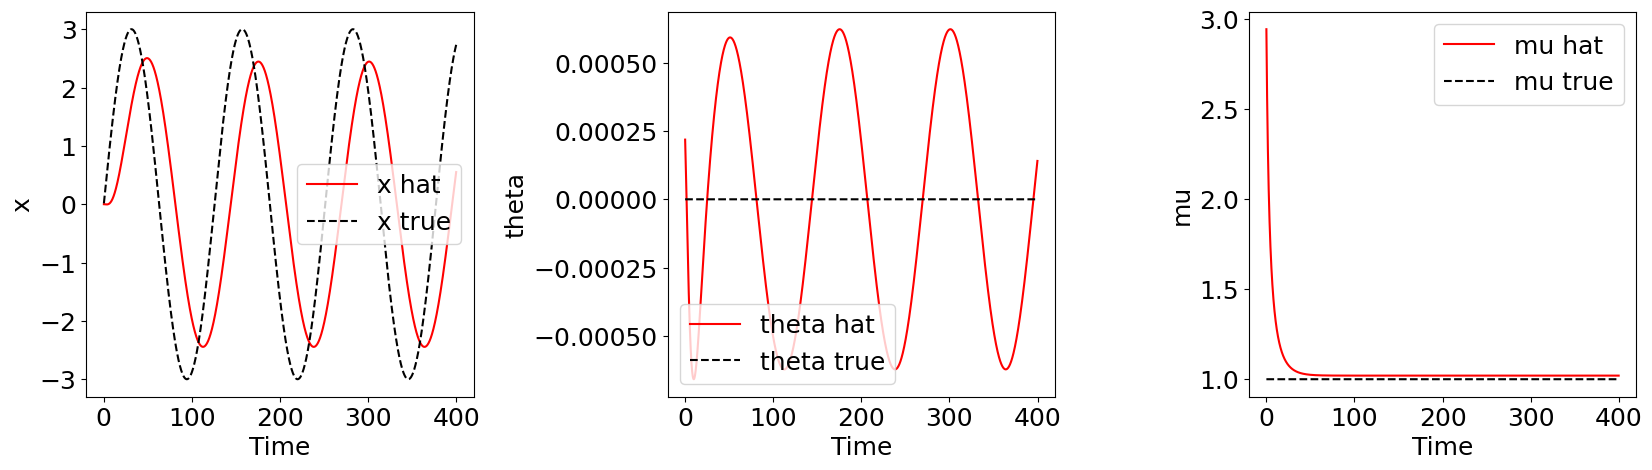

In [51]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu_des, None, mu, label_var='mu', ax=ax3)

Add noise to measurements

In [52]:
v = np.array([0.01, 0.001, 0.05, 0.0001, 0.0001])
noise = np.array( [np.random.normal(0, vi, Y.shape[1]) for vi in v] )

In [53]:
Ynoisy = Y + noise

(-0.5, 0.5)

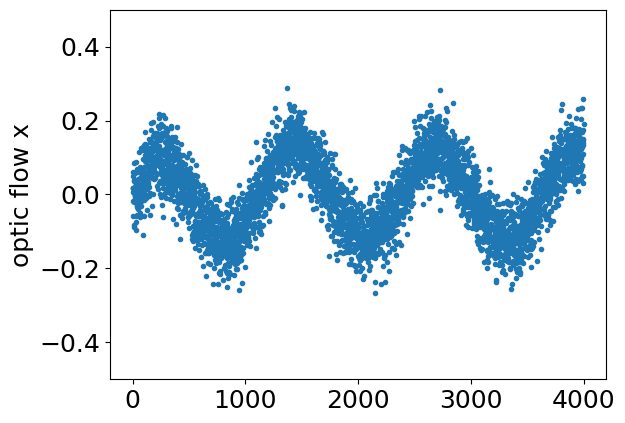

In [54]:
plt.plot(Ynoisy[2,:], '.')
plt.ylabel('optic flow x')
plt.ylim(-.5,.5)

Text(0, 0.5, 'Accel x')

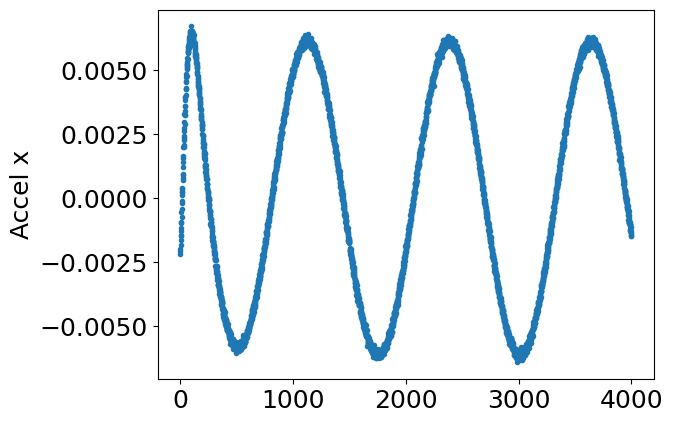

In [55]:
plt.plot(Ynoisy[3,:], '.')
#plt.ylim(-.05,.05)
plt.ylabel('Accel x')

# Import EKF

In [56]:
#!pip install git+https://github.com/florisvb/pyEKF.git

In [57]:
#import ekf

# EKF with correct mass

Requires very small Q to estimate states -- strong reliance on model!

### Initial conditions

In [82]:
# Initial conditions
x0 = np.hstack(([(np.random.random()-0.5)*1e-3 for i in range(4)], 5, 0,.005))
x0 = np.atleast_2d(x0).T
#x0 = np.vstack((x0, 0.01))
# add mass state to X

P0 = 1e-2*np.eye(X.shape[0])

# Noise defined by measurement noise
R = np.diag(v**2)

# Fairly accurate model
Q = 5e-8*np.eye(X.shape[0])

In [83]:
U.shape

(2, 3999)

### Dynamics

In [84]:
def f_d(X, U):
    dt=0.1
    theta, thetadot, x, xdot, mu, mudot,m = np.ravel(X)
    # m = 2 ## << true value is 2
    I = 2/5*m*l**2
    F, tau = np.ravel(U)
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta)-m*g)/m
    d_mudot = -1*( d_zdot + 2*z*zdot*mudot) / z**2
        
        
        

    new_theta = theta + thetadot*dt
    new_thetadot = tau/I
    new_x = x + xdot*dt
    new_xdot = xdot + -F*np.sin(theta)/m*dt
    new_mu = mu + mudot*dt
    new_mudot = mudot + d_mudot*dt
    new_m = m

    new_x = np.atleast_2d(np.array([new_theta, new_thetadot, new_x, new_xdot, new_mu, new_mudot,m])).T

    return new_x

def h_d(X, U):
    theta, thetadot, x, xdot, mu, mudot,m = np.ravel(X)
    
    if mu < 0.01:
        mu = 0.01
    if mu > 1000:
        mu = 1000
        
    if mudot < -5:
        mudot = -5
    if mudot > 5:
        mudot = 5
    
    F = np.ravel(U)[0]
    xddot_direct = -F*np.sin(theta)/m
    
    z = 1/mu
    zdot = -mudot*z**2
    d_zdot = (F*np.cos(theta)-m*g)/m
    muddot_direct = -1*( d_zdot + 2*z*zdot*mudot) / z**2

    y = np.atleast_2d(np.array([theta, thetadot, xdot*mu, xddot_direct, d_zdot])).T

    return y

In [85]:
xhat, P, s = ekf(Ynoisy, x0, f_d, h_d, Q, R, U)

In [86]:
theta_hat = xhat[0, :]
x_hat = xhat[2, :]
mu_hat = xhat[4, :]

theta_dot_hat = xhat[1, :]
x_dot_hat = xhat[3, :]
mu_dot_hat = xhat[5, :]
m_hat = xhat[6, :]

<Axes: xlabel='Time', ylabel='m'>

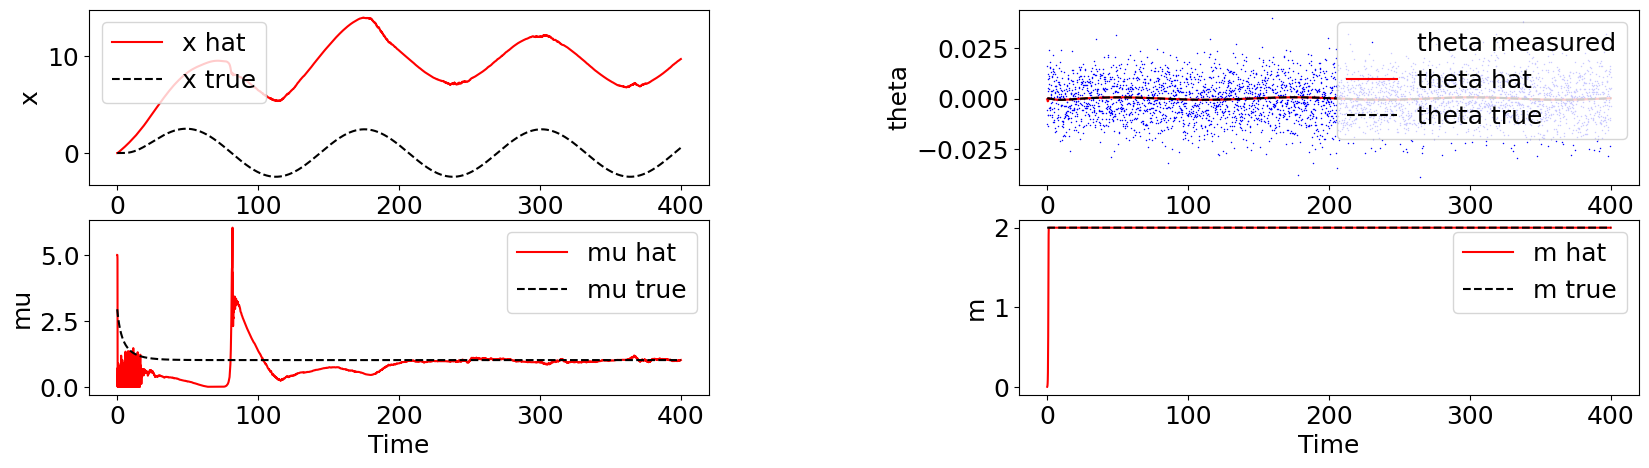

In [87]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(221)
plot_tme(tsim, x, None, x_hat, label_var='x', ax=ax1)

ax2 = fig.add_subplot(222)
plot_tme(tsim, theta, Ynoisy[0,:], theta_hat, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(223)
plot_tme(tsim, mu, None, mu_hat, label_var='mu', ax=ax3)

ax4 = fig.add_subplot(224)
plot_tme(tsim, np.array([2 for i in range(X.shape[1])]), None, m_hat, label_var='m', ax=ax4)

<Axes: xlabel='Time', ylabel='mu_dot'>

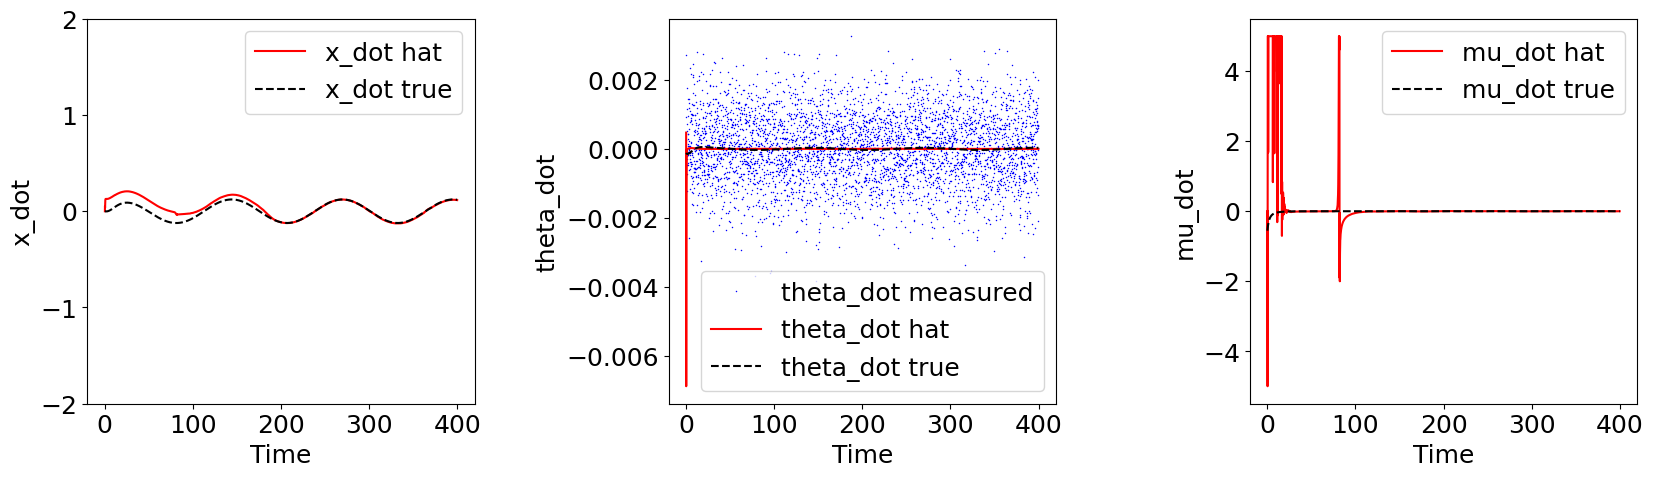

In [88]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(tsim, x_dot, None, x_dot_hat, label_var='x_dot', ax=ax1)
ax1.set_ylim(-2,2)

ax2 = fig.add_subplot(132)
plot_tme(tsim, theta_dot, Ynoisy[1,:], theta_dot_hat, label_var='theta_dot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(tsim, mu_dot, None, mu_dot_hat, label_var='mu_dot', ax=ax3)
#ax3.set_ylim(0, 5)

Text(0.5, 0, 'time')

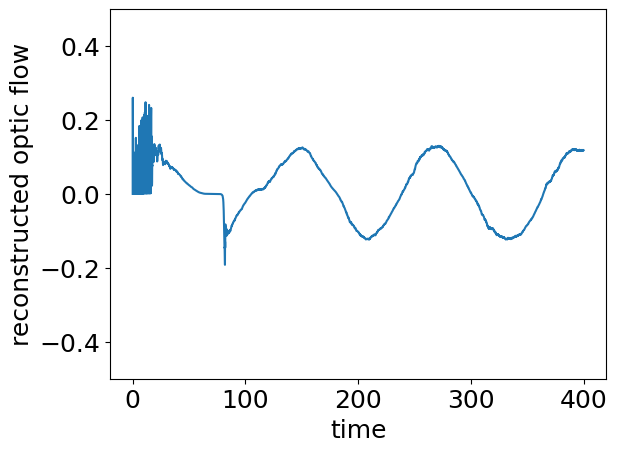

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(tsim, x_dot_hat*mu_hat)
ax.set_ylim(-0.5,.5)

ax.set_ylabel('reconstructed optic flow')
ax.set_xlabel('time')